# **Event Detection Using Bert**
Trained and evaluated the pre-trained BERT classification model with a labeled dataset created from the tweets of some news pages. BBC, CNN, Al-Jazeera, Reuters news pages are chosen as primary corpus.

# Installing Required packages

**Installing Simple Transformation package**

In [ ]:
#!pip install tweet-preprocessor

In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 215kB 5.9MB/s 
     |████████████████████████████████| 2.0MB 19.8MB/s 
     |████████████████████████████████| 1.2MB 38.3MB/s 
     |████████████████████████████████| 317kB 38.5MB/s 
     |████████████████████████████████| 1.9MB 40.5MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 7.5MB 38.9MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 3.2MB 31.3MB/s 
     |████████████████████████████████| 163kB 37.3MB/s 
     |████████████████████████████████| 133kB 41.9MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
     |████████████████████████████████| 890kB 37.8MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 112kB 42.7MB/s 
     |████████████████████████████████| 4.6MB 35.6MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 122kB 39.6MB/s 
 

# Importing Required Modules

All the required modules are imported for the model. For PyTorch, GPU is used and checked if available or not. And using TensorFlow, the GPU name is checked. In case if the GPU is not available, please use the CPU.

In [ ]:
import pandas as pd
import numpy as np
import torch
import csv
import sys
import re
import dlib
import string
import os
import tarfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel
from sklearn.metrics import f1_score, accuracy_score
torch.cuda.is_available()
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset Reading
Using pandas, the dataset from google drive is read. The first few data using head() function is printed.

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/FYDP2 Per/Defence Records and Rough/yes_no 500.csv", usecols=['tweet','label'])
df.head(20)

,tweet,label
0,RT @BBCR1: 🎆 Happy New Year! 🎆 https://t.co/yz...,no
1,RT @BBC6Music: 🅗🅐🅟🅟🅨 🅝🅔🅦 🅨🅔🅐🅡\n\n#HappyNewYear...,no
2,RT @BBCRadio2: 🎇🎉 HAPPY NEW YEAR! 🎉🎆\n\nLet's ...,no
3,RT @bbcideas: Happy new year to all our follow...,no
4,RT @BBCMOTD: 🎉 HAPPY NEW YEAR 🎉\n\n2010s it wa...,no
5,RT @BBCRadioScot: Happy New Year!!! Bliadhna M...,no
6,RT @BBCOne: January sucks but never fear... #D...,no
7,How did you celebrate?\n\nImages from New Year...,no
8,The story behind @LiamGallagher and @Coldplay’...,yes
9,RT @bbcthree: Five vegans are on a mission to ...,no


# Data Preprocessing
The dataset has been cleaned, as tweets contain hashtags, links, usernames, and emojis.

**Functions for data cleaning**

Some manual functions are used for removing links, hashtags, user name, retweets, emojis, and punctuation.

In [ ]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

punct =[]
punct += list(string.punctuation)
punct += '’'
punct += '\n'
punct += '“'
punct.remove("'")
def remove_punctuations(tweet):
    for punctuation in punct:
        tweet = tweet.replace(punctuation, ' ')
    return tweet

**Calling the functions for cleaning the dataset and printing cleaned data.**

In [ ]:
df['tweet'] = df['tweet'].apply(remove_users)
df['tweet'] = df['tweet'].apply(remove_links)
df['tweet'] = df['tweet'].apply(remove_emoji)
df['tweet'] = df['tweet'].apply(remove_punctuations)

df.head(20)

,tweet,label
0,Happy New Year,no
1,HappyNewYear,no
2,HAPPY NEW YEAR Let's raise a toast to a ...,no
3,Happy new year to all our followers Here s ...,no
4,HAPPY NEW YEAR 2010s it was a pleasure ...,no
5,Happy New Year Bliadhna Mhath Ùr,no
6,January sucks but never fear Dracula sta...,no
7,How did you celebrate Images from New Year's...,no
8,The story behind and s performance at One Lo...,yes
9,Five vegans are on a mission to win over hea...,no


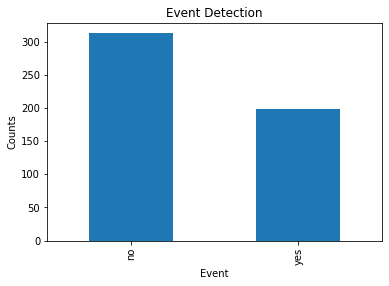

In [ ]:
plt.title('Event Detection')
plt.xlabel('Event')
plt.ylabel('Counts')
df['label'].value_counts().plot(kind = 'bar')
plt.show()

**Assigning numeric values for labels**

In [ ]:
class_list = ['no','yes']
df['label'] = df['label'].str.replace('\r', "")
df['pred_class'] = df.apply(lambda x:  class_list.index(x['label']),axis=1)


df = df[['tweet','pred_class']]

print(df.shape)
df.head()

(512, 2)


,tweet,pred_class
0,Happy New Year,0
1,HappyNewYear,0
2,HAPPY NEW YEAR Let's raise a toast to a ...,0
3,Happy new year to all our followers Here s ...,0
4,HAPPY NEW YEAR 2010s it was a pleasure ...,0


Label Counting

In [ ]:
df.pred_class.value_counts()

0    313
1    199
Name: pred_class, dtype: int64

**Lowercasing all the tweets**

Turned all the tweet words in lowercase.

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: x.lower())
df['tweet'] = df['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
df.head()

,tweet,pred_class
0,happy new year,0
1,happynewyear,0
2,happy new year lets raise a toast to a f...,0
3,happy new year to all our followers here s ...,0
4,happy new year 2010s it was a pleasure ...,0


# Spliting the dataset into train and test
For training and testing the model, the dataset is split using sklearn.

In [ ]:
train, test = train_test_split(df,test_size=0.3)
print('train shape: ',train.shape)
print('test shape: ',test.shape)

train shape:  (358, 2)
test shape:  (154, 2)


Printing Training data

In [ ]:
print(train)

                                                 tweet  pred_class
199  bmalawi declares state of disaster as two mini...           1
488  bhundreds of muslims attack and set fire to a ...           1
429  in 1976  lesley judd met anne franks father ot...           0
27     one day you re tattooing    or  and the next...           0
428  are you an introvert  heres why it can be a re...           0
..                                                 ...         ...
99   probably the best gesture ever made    themigh...           0
265  bpakistan xe2 x80 x99s president passes new bi...           1
295   the moment of crisis has come  in efforts to ...           0
58      onthisday 1981  the bbc television adaptati...           0
448    thank you so much for everyone who voted for...           0

[358 rows x 2 columns]


Printing Testing data

In [ ]:
print(test)

                                                 tweet  pred_class
405  we sent an adorable spy into the mountains of ...           0
423  b attacks on artistic freedom n nbangladesh di...           1
477  do you think you can tell the difference betwe...           0
93      searching for music  is like searching for ...           0
452    congratulations to  mrsbrownsboys for winnin...           0
..                                                 ...         ...
404   on january 25th  scottish people gather to ce...           0
459  we are shaken and stirred by this revelation  ...           0
207  bcanada show jumping team disqualified from ol...           1
137  climate change means the greenland ice sheet i...           0
221  bbomb and gun attacks in afghan capital kill t...           1

[154 rows x 2 columns]


# Creating Classification model
Made a classification model using a pre-trained BERT model called bert-base-uncased, which can work on both uppercase and lowercase words.

In [ ]:
# define hyperparameter
train_args ={"reprocess_input_data": True,
             "overwrite_output_dir": True,
             "fp16":False,
             "num_train_epochs": 4}

# Create a ClassificationModel
model = ClassificationModel(
    "bert", "bert-base-uncased",
    num_labels=2,
    args=train_args
)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

# Training the model with train data

In [ ]:
# Train the model
history=model.train_model(train)



/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:446: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/45 [00:00<?, ?it/s]

**Accuracy**

In [ ]:
def f1_binaryclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = model.eval_model(test, f1=f1_binaryclass, acc=accuracy_score)

result

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/20 [00:00<?, ?it/s]

{'acc': 0.9155844155844156,
 'auprc': 0.960643150692876,
 'auroc': 0.9573742540494459,
 'eval_loss': 0.3614277355372906,
 'f1': 0.9155844155844156,
 'fn': 8,
 'fp': 5,
 'mcc': 0.8292740005584845,
 'tn': 80,
 'tp': 61}

# Saving And Loading Model

In [ ]:
def save_model(model_path='',file_name=''):
  files = [files for root, dirs, files in os.walk(model_path)][0]
  with tarfile.open(file_name+ '.tar.gz', 'w:gz') as f:
    for file in files:
      f.add(f'{model_path}/{file}')

In [ ]:
save_model('outputs','bert_for_event')

In [ ]:
!tar -zxvf ./bert_for_event.tar.gz

outputs/eval_results.txt
outputs/model_args.json
outputs/config.json
outputs/special_tokens_map.json
outputs/vocab.txt
outputs/pytorch_model.bin
outputs/training_args.bin
outputs/tokenizer_config.json


In [ ]:
!rm -rf outputs

In [ ]:
def unpack_model(model_name=''): 
  tar = tarfile.open(f"{model_name}.tar.gz", "r:gz")
  tar.extractall()
  tar.close()

unpack_model('bert_for_event')

In [ ]:
# define hyperparameter
train_args ={"reprocess_input_data": True,
             "overwrite_output_dir": True,
             "fp16":False,
             "num_train_epochs": 4}

# Create a ClassificationModel
model = ClassificationModel(
    "bert", "outputs/",
    num_labels=2,
    args=train_args
)

# Testing with Tweets

In [ ]:
class_list = ['no','yes']

test_tweet = "Artcell is rocking the stage today"

predictions, raw_outputs = model.predict([test_tweet])

print(class_list[predictions[0]])

  0%|          | 0/1 [00:00<?, ?it/s]

no


In [ ]:
class_list = ['no','yes']

test_tweet = "Pekalongan city in Indonesia was flooded by crimson-colored waters from a local batik factory due to floods"

predictions, raw_outputs = model.predict([test_tweet])

print(class_list[predictions[0]])

  0%|          | 0/1 [00:00<?, ?it/s]

yes


In [ ]:
class_list = ['no','yes']

test_tweet = "Fahad is feeling sick due to fever"

predictions, raw_outputs = model.predict([test_tweet])

print(class_list[predictions[0]])

  0%|          | 0/1 [00:00<?, ?it/s]

no


In [ ]:
class_list = ['no','yes']

test_tweet = "It's the first major air crash in Indonesia since 189 passengers and crew were killed in 2018 when a Lion Air Boein"

predictions, raw_outputs = model.predict([test_tweet])

print(class_list[predictions[0]])

  0%|          | 0/1 [00:00<?, ?it/s]

yes


In [ ]:
print(result['tp'])

61


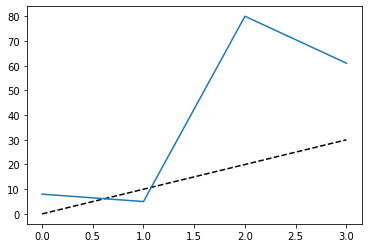

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fn=result['fn']
fp=result['fp']
tp=result['tp']
tn=result['tn']
ypoints = np.array([fn,fp, tn, tp])
plt.plot([0, 3], [0, 30], 'k--')
plt.plot(ypoints)
plt.show()